# Tuning LoRA Hyperparameters - Identifying Baselines and Initial Hyperparameters

## Environment Setup

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.append('src')

import sagemaker
from sagemaker.pytorch import PyTorch

import warnings
warnings.filterwarnings('ignore')

from src.util import (
    count_parameters,
    calc_combinations
)
from src.nb_helper import (
    display_tuning_jobs,
    get_default_estimator_parameters,
    p,
    capture_results,
    graph_results
)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/77/d3_lt6bx5pz4pqbb9dyn83zc0000gr/T/tmpf5gu7751
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/77/d3_lt6bx5pz4pqbb9dyn83zc0000gr/T/tmpf5gu7751/_remote_module_non_scriptable.py


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


## Establishing Baseline Performance and Hyperparameters
Before we run any experiment with LoRA itself, let's establish a performance baseline. 

This includes finding good hyperparameters. We'll just tune learning rate and orient ourselves with weight decay and dropout on the values used in the RoBERTa and LoRA papers. We use a little higher dropout (0.15) as in the papers (0.1). Keeping these hyperparameters fixed it will isolate the impact of the architectural changes (which components to adopt, what size of the components) and hence makes it easier to follow.
We are maintaining this approach through all notebooks. But if you are replicating this approach for your task and model, consider using the best found hyperparameter values, but then also tune for weight decay and dropout. This could be helpful to get the last bit of performance and to control variance.

Back to the baselines. We could capture data for three scenarios: 
- Random Performance (not captured, not interesting enough) 
- Training of the classifier head only, using the RoBERTa layers only in a feature-extractor-fashion (expectation: lower bound of performance)
- Full finetuning (expectation: higher bound of performance)

An an side, let's find out how many parameters we have in a model, **before** we add trainable parameters for LoRA. This way we find the true 100%. Later in these notebooks we use this information to calculate how many parameters we need to train for LoRA, relative to those 100% of the original model. 

In [4]:
from transformers import AutoModelForSequenceClassification

roberta_total, roberta_learnable = count_parameters(
    AutoModelForSequenceClassification.from_pretrained('roberta-base'), 
    verbose=False
)
roberta_learnable, roberta_total

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:src.util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


(124647170, 124647170)

### Full-Finetuning Performance
#### Initial Search

In [5]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter
from sagemaker.tuner import ContinuousParameter, HyperparameterTuner, HyperbandStrategyConfig, StrategyConfig, TuningJobCompletionCriteriaConfig

In [6]:
fullft_estimator = PyTorch(**get_default_estimator_parameters())
fullft_estimator.set_hyperparameters(**{'sst2-lora-config': 'none'})

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(1e-5, 6e-5),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Bayesian',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = fullft_estimator,
    base_tuning_job_name = 'full-finetuning',
    max_jobs = 15,
    max_parallel_jobs = 2,
    completion_criteria_config=TuningJobCompletionCriteriaConfig(complete_on_convergence=True)
))}

lr_wd_tuner = HyperparameterTuner(**tuner_parameters)
lr_wd_tuner.fit(wait=False)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: full-finetuning-231031-1649


In [7]:
clf_estimator = PyTorch(**get_default_estimator_parameters())
clf_estimator.set_hyperparameters(**{'sst2-lora-config': 'clf_only'})

hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(3e-5, 2e-3),
}

tuner_parameters = {**(p('tuner_parameters') | dict(
    strategy='Bayesian',
    hyperparameter_ranges=hpt_ranges,
    metric_definitions=p('metric_definitions'),
    estimator = clf_estimator,
    base_tuning_job_name = 'clf-only-tuning',
    max_jobs = 15,
    max_parallel_jobs = 2,
    completion_criteria_config=TuningJobCompletionCriteriaConfig(complete_on_convergence=True)
))}
lr_wd_clf_tuner = HyperparameterTuner(**tuner_parameters)
lr_wd_clf_tuner.fit(wait=False)

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: clf-only-tuning-231031-1649


### Find Initial Hyperparameters for LoRA Finetuning
We don't want to vary too many hyperparameters at the same time. Hence we fix the learning rate and weight decay. But as both hyperparameters can be significantly different for the low parameters learning regime with LoRA vs the high pararameters regime with a full finetuning, we will tune for some setting in the low parameters regime. And, maybe, at the end we will tune again with learning rate and weight decay again

In [8]:
lora_base_estimator = PyTorch(**get_default_estimator_parameters())
lora_base_estimator.set_hyperparameters(**{'sst2-lora-r': 8, 'sst2-lora-config': 'all', }) 
hpt_ranges = {
    'sst2-learning-rate': ContinuousParameter(5e-5, 3e-3),
}

max_jobs = 15
tuner_parameters = {**(p('tuner_parameters') | dict(
    metric_definitions=p('metric_definitions'),
    base_tuning_job_name= 'lora-base-tuning', 
    max_jobs=max_jobs,   
    strategy= 'Bayesian',
    hyperparameter_ranges= hpt_ranges,
    max_parallel_jobs=2,
    estimator=lora_base_estimator))}

base_lora_tuner = HyperparameterTuner(**tuner_parameters)
base_lora_tuner.fit(wait=False)
base_lora_tuner_name = base_lora_tuner.describe()["HyperParameterTuningJobName"]
%store base_lora_tuner_name

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: lora-base-tuning-231031-1649
Stored 'base_lora_tuner_name' (str)


### Analysis

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INFO:util:Total parameters: 124,647,170, thereof learnable: 124,647,170 (100.0000%)


'full-finetuning-231031-1649'

Tuning job full-finetuning-231031-1649 status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 15
Lowest: 0.9277523159980774 Highest 0.9461008906364441


,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
11,0.000049,full-finetuning-231031-1649-004-b6624358,Completed,2023-10-31 17:02:50+01:00,2023-10-31 17:13:09+01:00,619.0,full-finetuning-231031-1649,0.946101
2,0.000049,full-finetuning-231031-1649-013-a9c4328b,Completed,2023-10-31 17:56:15+01:00,2023-10-31 18:06:29+01:00,614.0,full-finetuning-231031-1649,0.943807
0,0.000049,full-finetuning-231031-1649-015-b25fc68f,Completed,2023-10-31 18:06:59+01:00,2023-10-31 18:17:38+01:00,639.0,full-finetuning-231031-1649,0.940367
8,0.000036,full-finetuning-231031-1649-007-bc152582,Completed,2023-10-31 17:25:32+01:00,2023-10-31 17:34:36+01:00,544.0,full-finetuning-231031-1649,0.939220
7,0.000049,full-finetuning-231031-1649-008-15ed7248,Completed,2023-10-31 17:25:27+01:00,2023-10-31 17:33:21+01:00,474.0,full-finetuning-231031-1649,0.938073
10,0.000033,full-finetuning-231031-1649-005-009aa502,Completed,2023-10-31 17:15:09+01:00,2023-10-31 17:23:23+01:00,494.0,full-finetuning-231031-1649,0.938073
1,0.000049,full-finetuning-231031-1649-014-71ce6b8e,Completed,2023-10-31 17:56:46+01:00,2023-10-31 18:04:44+01:00,478.0,full-finetuning-231031-1649,0.936927
3,0.000059,full-finetuning-231031-1649-012-6d9fc8a5,Completed,2023-10-31 17:47:30+01:00,2023-10-31 17:55:19+01:00,469.0,full-finetuning-231031-1649,0.936927
6,0.000038,full-finetuning-231031-1649-009-d35d4516,Completed,2023-10-31 17:35:53+01:00,2023-10-31 17:46:12+01:00,619.0,full-finetuning-231031-1649,0.936927
9,0.000039,full-finetuning-231031-1649-006-7d6b908f,Completed,2023-10-31 17:15:10+01:00,2023-10-31 17:23:04+01:00,474.0,full-finetuning-231031-1649,0.936927


Cache Hit/Miss: HHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


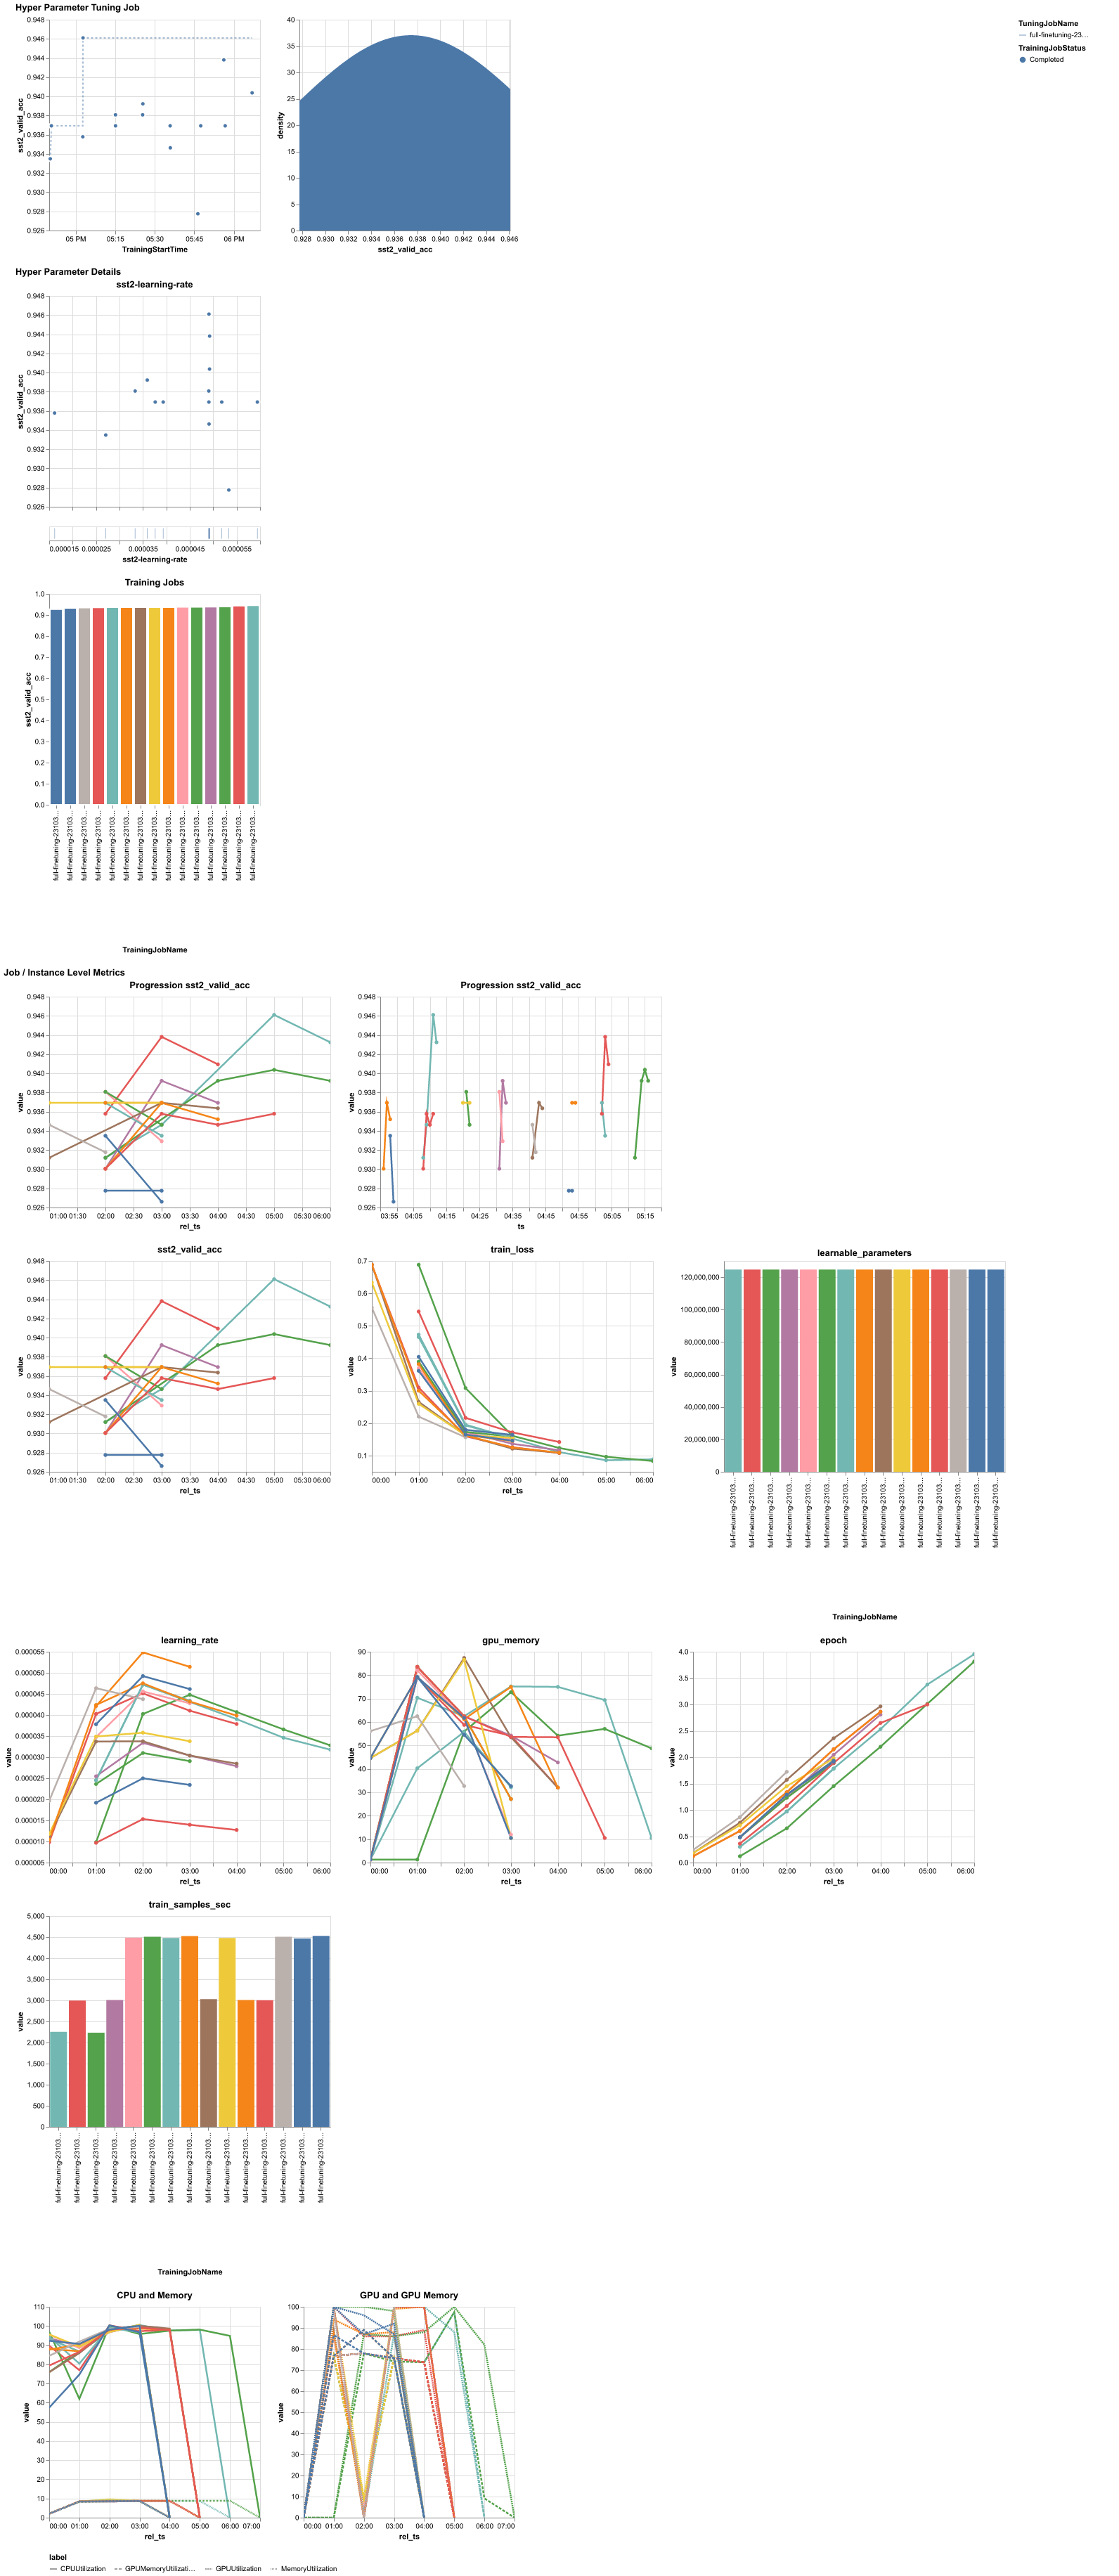

'clf-only-tuning-231031-1649'

Tuning job clf-only-tuning-231031-1649 status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 15
Lowest: 0.7981651425361633 Highest 0.8451834917068481


,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
8,0.001491,clf-only-tuning-231031-1649-007-baa6b566,Completed,2023-10-31 17:19:41+01:00,2023-10-31 17:27:25+01:00,464.0,clf-only-tuning-231031-1649,0.845183
14,0.001979,clf-only-tuning-231031-1649-001-18e9357d,Completed,2023-10-31 16:50:24+01:00,2023-10-31 16:59:07+01:00,523.0,clf-only-tuning-231031-1649,0.845183
0,0.001977,clf-only-tuning-231031-1649-015-04ef7398,Completed,2023-10-31 17:55:39+01:00,2023-10-31 18:03:23+01:00,464.0,clf-only-tuning-231031-1649,0.842890
10,0.001093,clf-only-tuning-231031-1649-005-29e93cf4,Completed,2023-10-31 17:09:13+01:00,2023-10-31 17:17:01+01:00,468.0,clf-only-tuning-231031-1649,0.840596
12,0.000863,clf-only-tuning-231031-1649-003-8816027f,Completed,2023-10-31 16:59:53+01:00,2023-10-31 17:07:31+01:00,458.0,clf-only-tuning-231031-1649,0.840596
3,0.001970,clf-only-tuning-231031-1649-012-66d30cc5,Completed,2023-10-31 17:37:33+01:00,2023-10-31 17:45:31+01:00,478.0,clf-only-tuning-231031-1649,0.839450
6,0.001978,clf-only-tuning-231031-1649-009-9883a526,Completed,2023-10-31 17:28:28+01:00,2023-10-31 17:35:11+01:00,403.0,clf-only-tuning-231031-1649,0.837156
2,0.001949,clf-only-tuning-231031-1649-013-0f1c21ce,Completed,2023-10-31 17:46:19+01:00,2023-10-31 17:53:28+01:00,429.0,clf-only-tuning-231031-1649,0.836009
4,0.001877,clf-only-tuning-231031-1649-011-6686f264,Completed,2023-10-31 17:37:27+01:00,2023-10-31 17:44:10+01:00,403.0,clf-only-tuning-231031-1649,0.830275
7,0.002000,clf-only-tuning-231031-1649-008-5844698f,Completed,2023-10-31 17:19:49+01:00,2023-10-31 17:26:37+01:00,408.0,clf-only-tuning-231031-1649,0.829128


Cache Hit/Miss: HHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN x-scale's "zero" is dropped as it does not work with log scale.
WARN x-scale's "zero" is dropped as it does not work with log scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


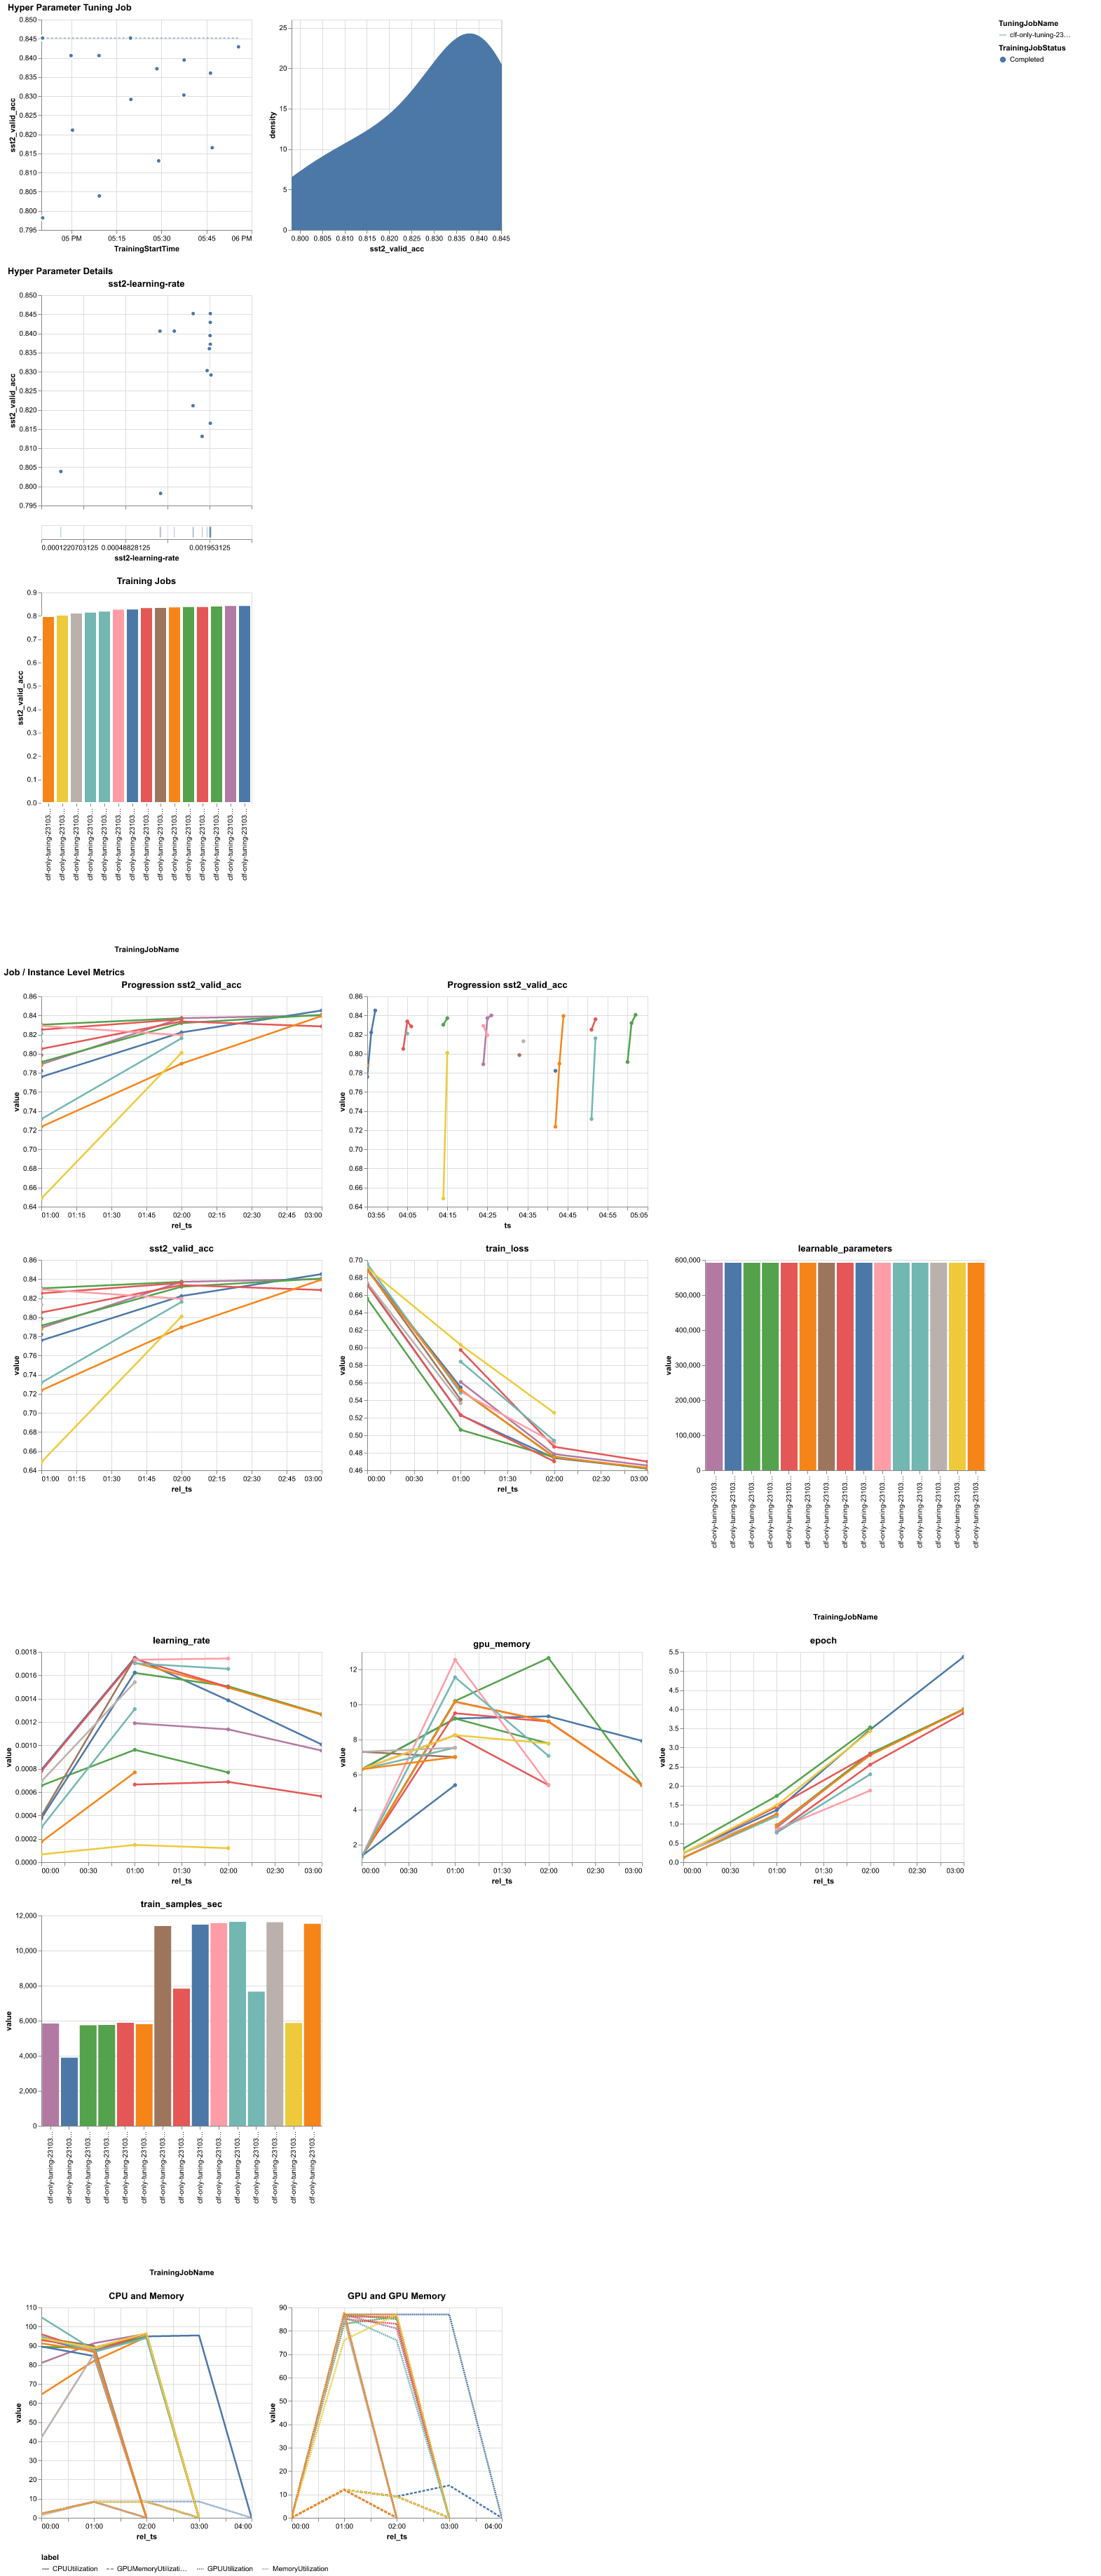

'lora-base-tuning-231031-1649'

Tuning job lora-base-tuning-231031-1649 status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 15
Lowest: 0.9277523159980774 Highest 0.9449541568756104


,sst2-learning-rate,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
1,0.002114,lora-base-tuning-231031-1649-014-b24df4a7,Completed,2023-10-31 18:06:47+01:00,2023-10-31 18:21:32+01:00,885.0,lora-base-tuning-231031-1649,0.944954
3,0.002126,lora-base-tuning-231031-1649-012-4dbc419b,Completed,2023-10-31 17:54:19+01:00,2023-10-31 18:04:57+01:00,638.0,lora-base-tuning-231031-1649,0.942661
0,0.002122,lora-base-tuning-231031-1649-015-04958ffe,Completed,2023-10-31 18:19:16+01:00,2023-10-31 18:29:55+01:00,639.0,lora-base-tuning-231031-1649,0.941514
14,0.002198,lora-base-tuning-231031-1649-001-64a1e8d2,Completed,2023-10-31 16:51:16+01:00,2023-10-31 17:05:41+01:00,865.0,lora-base-tuning-231031-1649,0.941514
4,0.002191,lora-base-tuning-231031-1649-011-07b725cf,Completed,2023-10-31 17:52:58+01:00,2023-10-31 18:03:47+01:00,649.0,lora-base-tuning-231031-1649,0.940367
9,0.002128,lora-base-tuning-231031-1649-006-b4fb26c8,Completed,2023-10-31 17:17:29+01:00,2023-10-31 17:29:03+01:00,694.0,lora-base-tuning-231031-1649,0.940367
2,0.001912,lora-base-tuning-231031-1649-013-c70e5933,Completed,2023-10-31 18:06:53+01:00,2023-10-31 18:17:32+01:00,639.0,lora-base-tuning-231031-1649,0.939220
5,0.002187,lora-base-tuning-231031-1649-010-9b4d5000,Completed,2023-10-31 17:42:28+01:00,2023-10-31 17:53:02+01:00,634.0,lora-base-tuning-231031-1649,0.939220
6,0.002166,lora-base-tuning-231031-1649-009-25256aae,Completed,2023-10-31 17:40:44+01:00,2023-10-31 17:51:28+01:00,644.0,lora-base-tuning-231031-1649,0.936927
7,0.002207,lora-base-tuning-231031-1649-008-e53ed4e6,Completed,2023-10-31 17:30:22+01:00,2023-10-31 17:41:01+01:00,639.0,lora-base-tuning-231031-1649,0.935780


Cache Hit/Miss: HHHHHHHHHHHHHHH


WARN shape dropped as it is incompatible with "bar".
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN x-scale's "base" is dropped as it does not work with linear scale.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.
WARN Scale bindings are currently only supported for scales with unbinned, continuous domains.


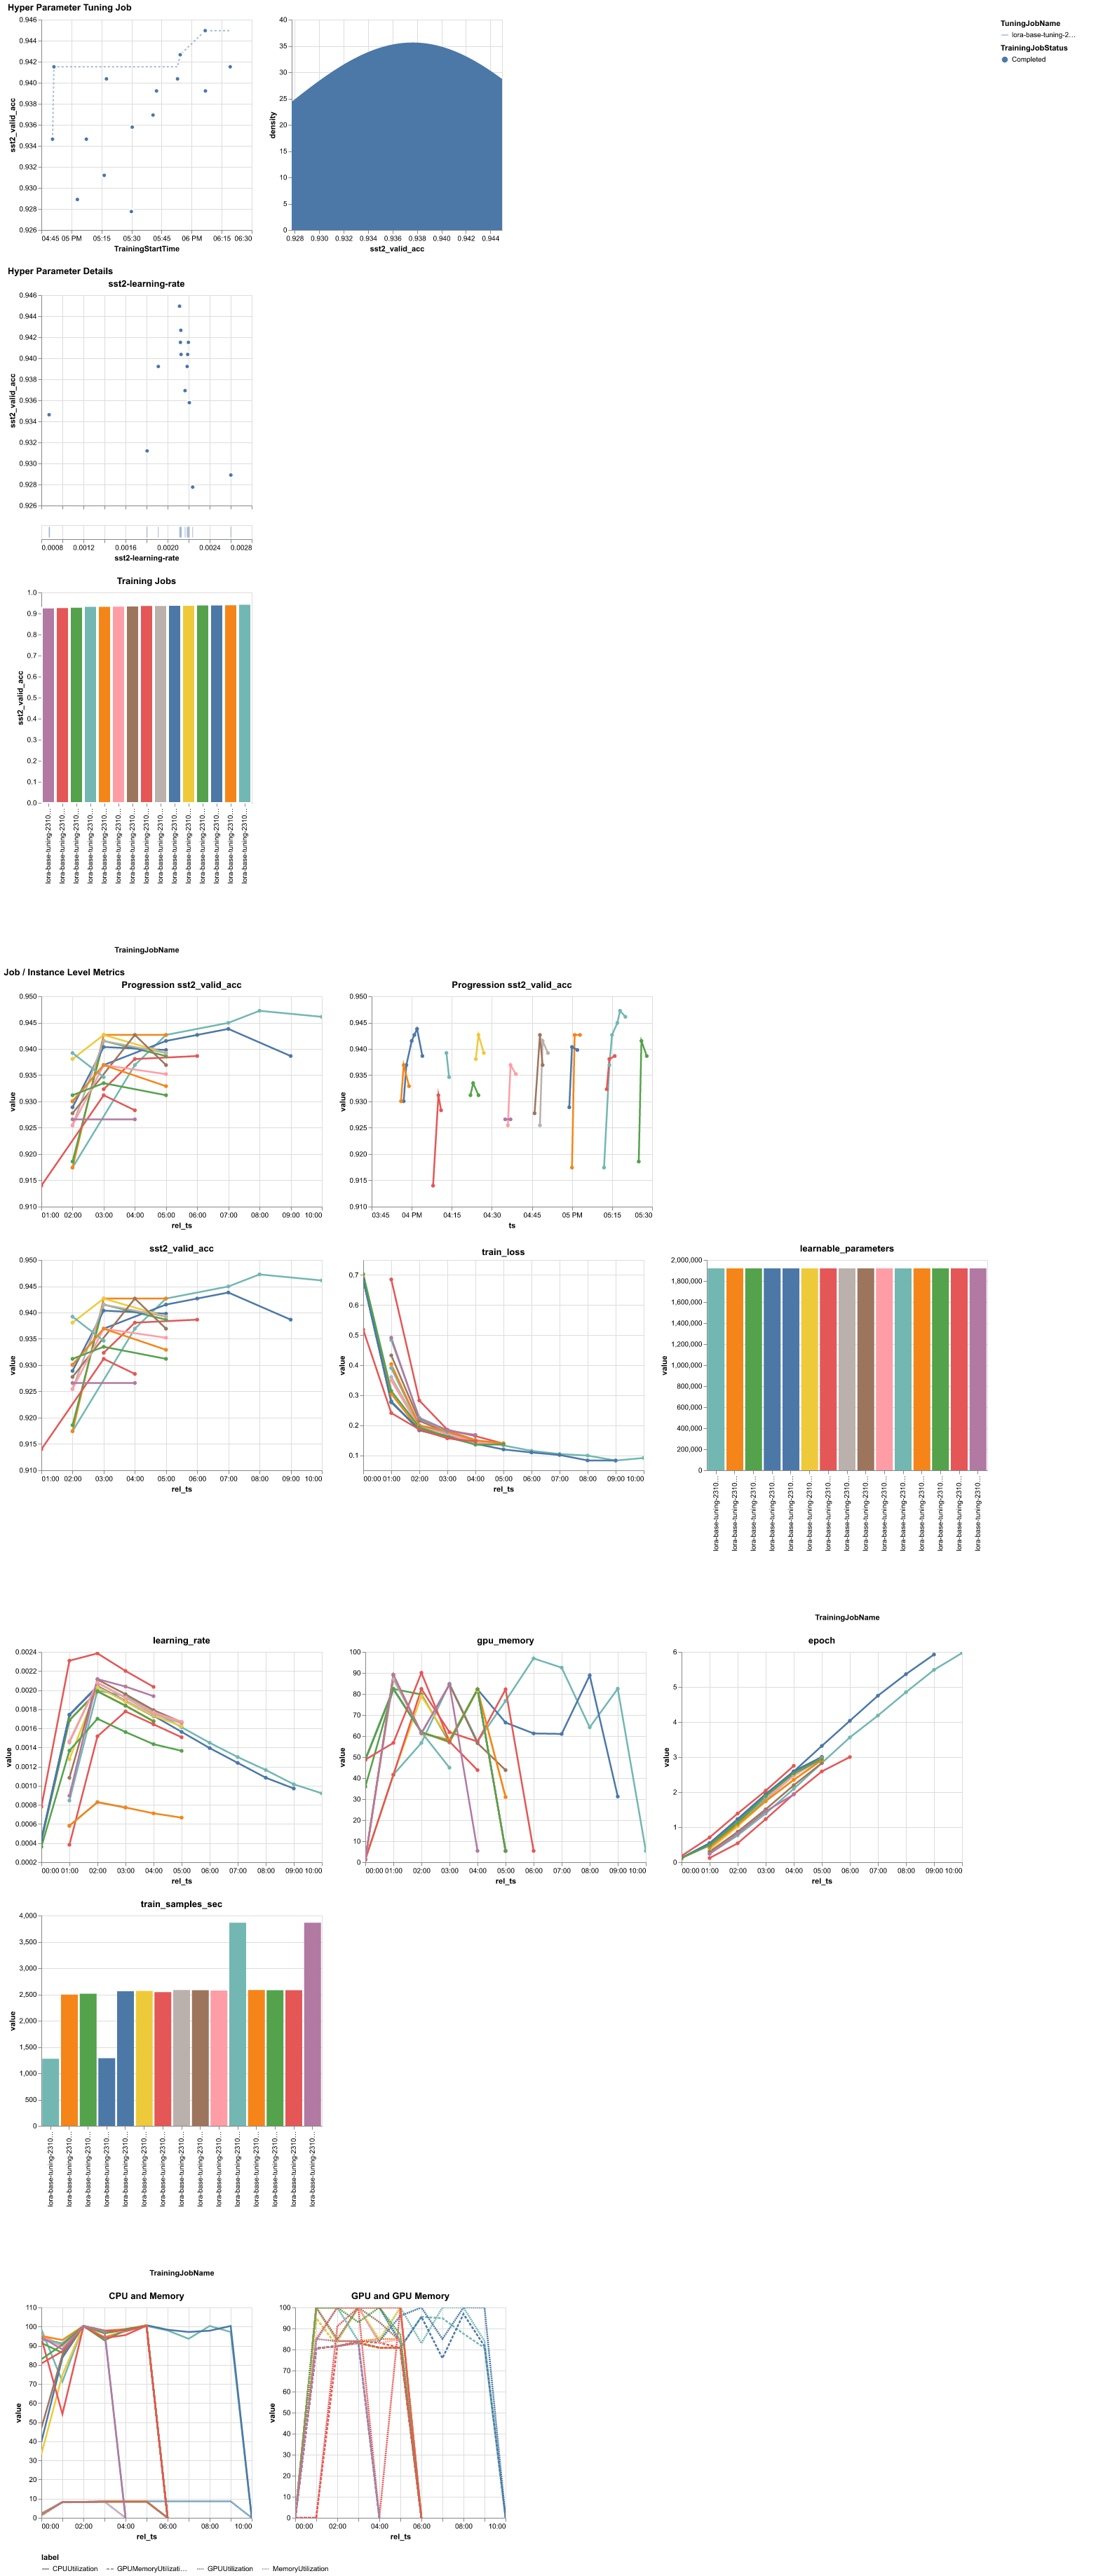

In [10]:
display_tuning_jobs([lr_wd_tuner, lr_wd_clf_tuner, base_lora_tuner])

So far so good. But now we don't want to find the best hyperparameter values, but want to sample certain combinations to judge their impact. While above we used Bayesian Optimization to search for hyperparameters, which takes the results from earlier trials to inform which hyperparameter values to pick for new trials, below we will now use a Random Search. Here we want to sample from the possible search space and don't take into account early results. 
This way we can focus on the exploration and don't bias our later trials to sample more often from the areas that are already recognized as impactful, as Bayesian Search would do, but keep sampling.

#### Capture Results

In [10]:
capture_results('Full Finetuning', fullft_estimator, lr_wd_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-231031-1830
..........................................................................................................................!
Tuning job capture-231031-1830       status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 3
Lowest: 0.9300458431243896 Highest 0.9380733966827393


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,1.0,capture-231031-1830-001-709d6424,Completed,2023-10-31 18:31:49+01:00,2023-10-31 18:39:52+01:00,483.0,capture-231031-1830,0.938073
1,2.0,capture-231031-1830-002-0b986b87,Completed,2023-10-31 18:31:51+01:00,2023-10-31 18:39:49+01:00,478.0,capture-231031-1830,0.934633
0,3.0,capture-231031-1830-003-9795793a,Completed,2023-10-31 18:31:55+01:00,2023-10-31 18:39:48+01:00,473.0,capture-231031-1830,0.930046


Cache Hit/Miss: MMM


In [11]:
capture_results('Classifier Only', clf_estimator, lr_wd_clf_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-231031-1841
.......................................................................................................!
Tuning job capture-231031-1841       status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 3
Lowest: 0.7832568883895874 Highest 0.8394495248794556


,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,1.0,capture-231031-1841-001-f9f17dbe,Completed,2023-10-31 18:42:33+01:00,2023-10-31 18:49:26+01:00,413.0,capture-231031-1841,0.839450
1,2.0,capture-231031-1841-002-6eab5a75,Completed,2023-10-31 18:42:23+01:00,2023-10-31 18:49:11+01:00,408.0,capture-231031-1841,0.802752
0,3.0,capture-231031-1841-003-2c268ce6,Completed,2023-10-31 18:42:26+01:00,2023-10-31 18:49:14+01:00,408.0,capture-231031-1841,0.783257


Cache Hit/Miss: MMM


In [12]:
capture_results('LoRA Base', lora_base_estimator, base_lora_tuner) 

Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-231031-1850
.............................................................................................................................................................................................................!
Tuning job capture-231031-1850       status: Completed
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml

Number of training jobs with valid objective: 3
Lowest: 0.9

,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
2,0.0,capture-231031-1850-001-da19eee1,Completed,2023-10-31 18:51:23+01:00,2023-10-31 19:05:53+01:00,870.0,capture-231031-1850,0.950688
1,2.0,capture-231031-1850-002-a86519ba,Completed,2023-10-31 18:51:21+01:00,2023-10-31 19:04:20+01:00,779.0,capture-231031-1850,0.947248
0,3.0,capture-231031-1850-003-95aea2bf,Completed,2023-10-31 18:51:26+01:00,2023-10-31 19:02:05+01:00,639.0,capture-231031-1850,0.938073


Cache Hit/Miss: MMM


In [14]:
lora_paper_estimator = PyTorch(**get_default_estimator_parameters())
lora_paper_estimator.set_hyperparameters(**{
    'sst2-lora-r': 8, 
    'sst2-lora-config': 'query|value', 
    'patience': 1,
    'sst2-batch-size': 16*8,
    'sst2-learning-rate': 5e-4,
    'sst2-weight-decay': 0.1,
    'sst2-lora-dropout': 0.1, 
    'clf-dropout': 0.0, 
    'sst2-weight-decay': 0.01,
    'sst2-epochs': 10} ) # 60 in the paper, 10 in the script
capture_results('LoRA Paper', lora_paper_estimator) 
# bs 16 is from the paper, but not efficient for an A10G. The script also points to 16 per one of their 8 GPUs. 
# Did not find dropout for SST-2 RoBERTa base in the paper. Using 0.1 given that we have 60 (10?) epochs.
# The paper specified alpha of 8 for r=8, but the sst2 script shows alpha of 16. Also, 60 epochs from the paper is then 10 epochs in the script.
# Tried with and without alpha, but removed alpha for simplicity, after seeing it has no original impact, and we are tuning lr anyway.
# https://github.com/microsoft/LoRA/blob/main/examples/NLU/roberta_large_sst2.sh
# -> Could not reproduce. Neither the performance, nor even creating the original environment.

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Library/Preferences/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/mkamp/Library/Preferences/sagemaker/config.yaml
Using provided s3_resource
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: capture-231031-1914
............................................................................................................................................................................................................!
Tuning job capture-231031-1914       status: Completed
sagemaker.config INFO - Not applying SDK defaults from locati

,dummy,TrainingJobName,TrainingJobStatus,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds,TuningJobName,sst2_valid_acc
0,3.0,capture-231031-1914-003-ce855f61,Completed,2023-10-31 19:16:17+01:00,2023-10-31 19:32:13+01:00,956.0,capture-231031-1914,0.948394
2,0.0,capture-231031-1914-001-79ce37b5,Completed,2023-10-31 19:16:09+01:00,2023-10-31 19:24:58+01:00,529.0,capture-231031-1914,0.936927
1,1.0,capture-231031-1914-002-4fe29cdc,Completed,2023-10-31 19:16:06+01:00,2023-10-31 19:25:05+01:00,539.0,capture-231031-1914,0.934633


Cache Hit/Miss: MMM


,target_tuner_name,title,objective_metric_mean,objective_metric_std,parameters_relative,train_speed_median,gpu_memory_max
0,capture-231031-1830,Full Finetuning,0.934251,0.004027,100.000000,4501.284,62.466667
1,capture-231031-1841,Classifier Only,0.808486,0.028532,0.475045,11435.892,8.600000
2,capture-231031-1850,LoRA Base,0.945336,0.006521,1.539733,1541.591,90.050000
3,capture-231031-1914,LoRA Paper,0.939985,0.007373,0.711642,3559.035,22.466667


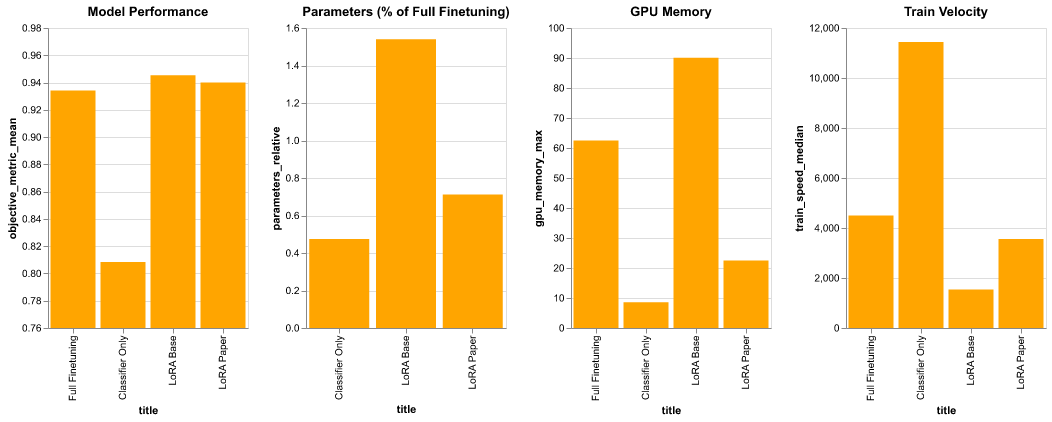

In [12]:
graph_results()